In [2]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yaml

import pdcast as pdc

while not Path("data") in Path(".").iterdir():
    os.chdir("..")

import mscproject.features as feats
import mscproject.preprocess as pre
import mscproject.pygloaders as pgl
from mscproject.metrics import EvalMetrics
import catboost as cb

In [3]:
# Read config.
conf_dict = yaml.safe_load(Path("config/conf.yaml").read_text())

features_path = conf_dict["features_path"]

In [4]:
# Load features for data split.
def load_features(path_root):
    companies_df = pd.read_parquet(conf_dict["companies_features"])
    persons_df = pd.read_parquet(conf_dict["persons_features"])
    return companies_df, persons_df

In [5]:
companies_df, persons_df = load_features(features_path)

ImportError: Unable to find a usable engine; tried using: 'pyarrow', 'fastparquet'.
A suitable version of pyarrow or fastparquet is required for parquet support.
Trying to import the above resulted in these errors:
 - Missing optional dependency 'pyarrow'. pyarrow is required for parquet support. Use pip or conda to install pyarrow.
 - Missing optional dependency 'fastparquet'. fastparquet is required for parquet support. Use pip or conda to install fastparquet.

In [ ]:
common_cols = set(companies_df.columns) & set(persons_df.columns)
drop_cols = ["id", "name", "component"]
select_cols = sorted(common_cols.difference(drop_cols))

target = "is_anomalous"

entities_df = pd.concat([companies_df, persons_df], axis=0)[list(common_cols)]

In [ ]:
masks = pgl.get_data_split_masks(entities_df)

In [ ]:
train_df = entities_df.loc[list(masks.train.numpy())].drop(drop_cols, axis=1)
valid_df = entities_df.loc[list(masks.val.numpy())].drop(drop_cols, axis=1)
test_df = entities_df.loc[list(masks.test.numpy())].drop(drop_cols, axis=1)

In [ ]:
train_df.query("isCompany == False and indegree > 0")

,neighbourhood_closeness,pagerank,indegree,is_anomalous,outdegree,neighbour_count,neighbourhood_indegree,neighbourhood_clustering,neighbourhood_neighbour_count,isCompany,neighbourhood_outdegree,closeness,neighbourhood_pagerank,clustering


In [ ]:
# Create train, test, and valid pools for CatBoost.

cat_features = ["isCompany"]

X_train = train_df.drop(target, axis=1)
y_train = train_df[target].astype(np.int8)

X_valid = valid_df.drop(target, axis=1)
y_valid = valid_df[target].astype(np.int8)

X_test = test_df.drop(target, axis=1)
y_test = test_df[target].astype(np.int8)

In [ ]:
train_pool = cb.Pool(
    X_train.to_numpy(),
    y_train.to_numpy(),
    cat_features=cat_features,
    feature_names=X_train.columns.to_list(),
)

valid_pool = cb.Pool(
    X_valid.to_numpy(),
    y_valid.to_numpy(),
    cat_features=cat_features,
    feature_names=X_valid.columns.to_list(),
)

test_pool = cb.Pool(
    X_test.to_numpy(),
    y_test.to_numpy(),
    cat_features=cat_features,
    feature_names=X_test.columns.to_list(),
)

In [ ]:
class_weights = {0: 1, 1: 10}

In [ ]:
# Create CatBoost model.
clf = cb.CatBoostClassifier(
    iterations=2001,
    # learning_rate=0.1,
    depth=6,
    # eval_metric="Accuracy",
    class_weights=class_weights,
    random_seed=42,
    loss_function="AUC"
)


# Fit model.
clf.fit(
    train_pool,
    eval_set=valid_pool,
    use_best_model=True,
    verbose=200,
)

NameError: name 'cb' is not defined

In [ ]:
# Print confusion matrix.
y_pred = clf.predict(test_pool)
print(pd.crosstab(y_test, y_pred, rownames=["Actual"], colnames=["Predicted"]))

Predicted     0     1
Actual               
0          3572  3741
1           190   511


In [ ]:
# Evaluate model.
y_test_pred = np.array([x[1] for x in clf.predict_proba(test_pool)])
eval_metrics = EvalMetrics.from_numpy(y_test_pred, y_test.to_numpy())
print(eval_metrics)

loss: 0.6129, accuracy: 0.9125, precision: 0.1202, recall: 0.7290, f1: 0.2063, auroc: 0.6724, average_precision: 0.2767


In [ ]:
# Get Shapley values.
shap_values = clf.get_feature_importance(test_pool, type="ShapValues")[:, 1:]


import shap

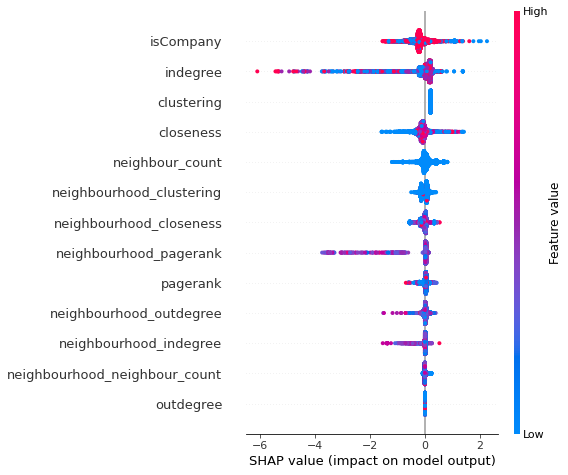

In [ ]:
shap.summary_plot(shap_values, X_test)

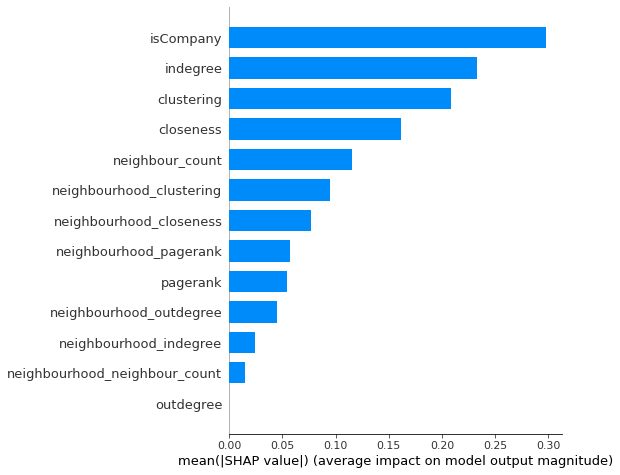

In [ ]:
# Plot partial dependence plots.
shap.summary_plot(shap_values, X_test, plot_type="bar")

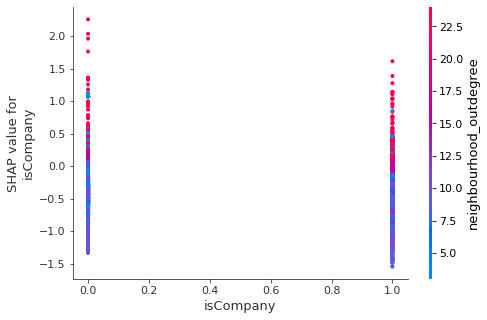

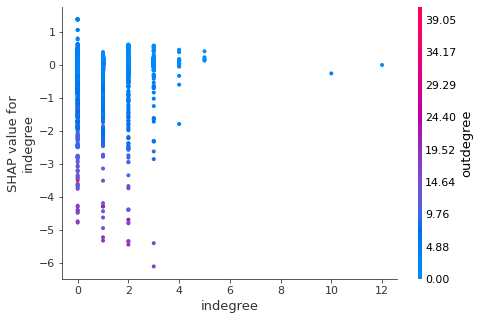

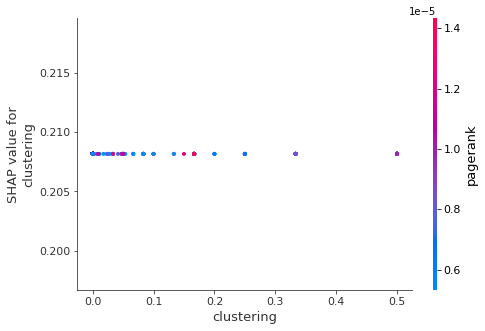

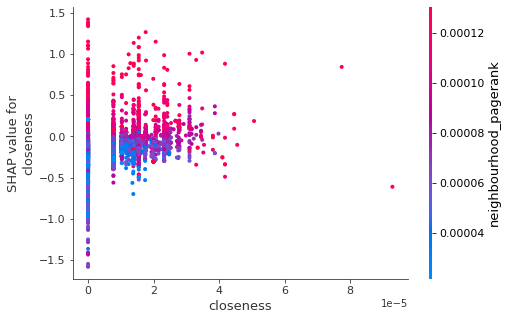

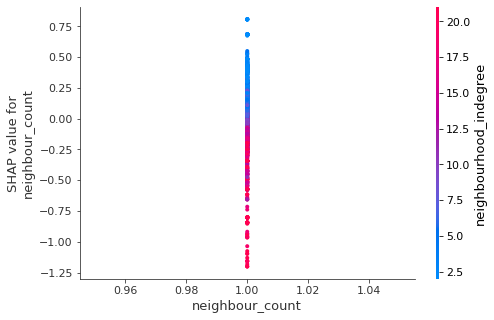

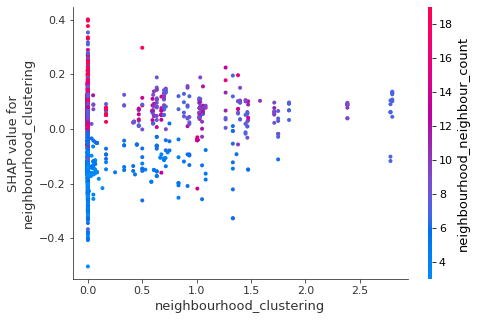

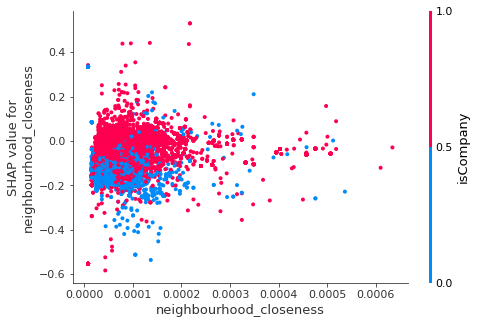

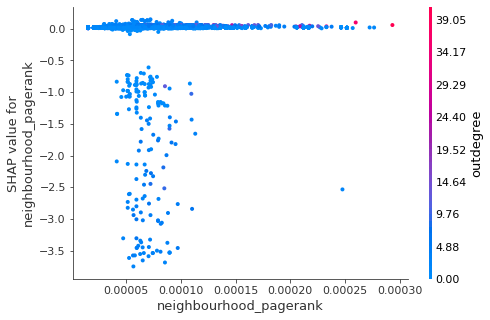

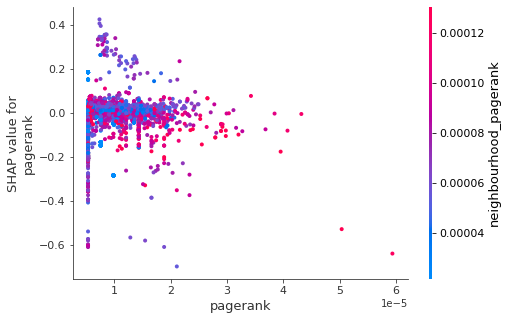

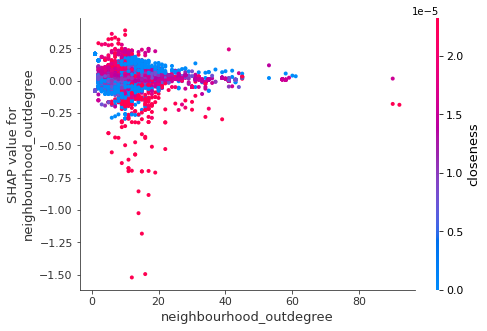

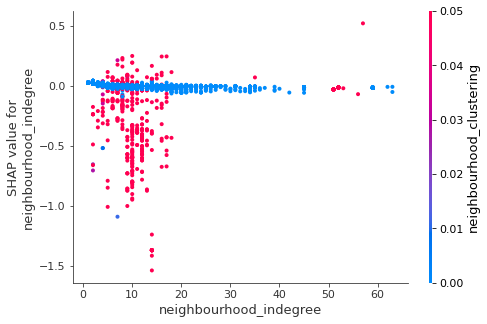

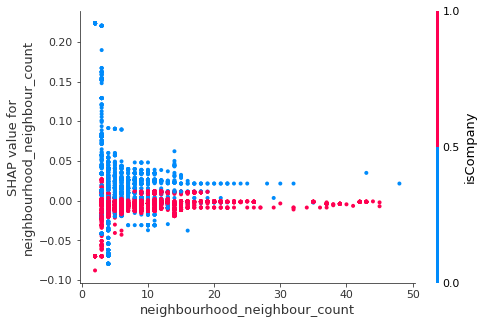

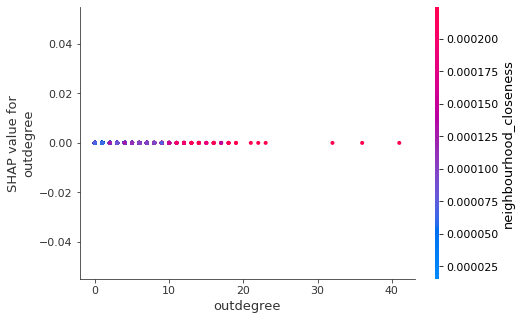

In [ ]:
for i in range(X_test.shape[1]):
    shap.dependence_plot(f"rank({i})", shap_values, X_test)
    plt.show()